In [25]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/grupo-bimbo-inventory-demand/town_state.csv.zip
/kaggle/input/grupo-bimbo-inventory-demand/train.csv.zip
/kaggle/input/grupo-bimbo-inventory-demand/sample_submission.csv.zip
/kaggle/input/grupo-bimbo-inventory-demand/producto_tabla.csv.zip
/kaggle/input/grupo-bimbo-inventory-demand/cliente_tabla.csv.zip
/kaggle/input/grupo-bimbo-inventory-demand/test.csv.zip


<div style="border-radius:10px; padding: 12px; background-color: #ffffff; font-size:130%; text-align:left">

<h2 align="left"><font color=#E1B12D>Introduction</font></h2>

Grupo Bimbo, a leading multinational bakery company, faces a unique challenge in managing the inventory of its products. With a typical shelf life of just one week, the accuracy of daily inventory calculations is paramount. Currently, these calculations are performed by direct delivery sales employees who rely on their personal experiences to predict the forces of supply, demand, and consumer behavior at each store. The margin for error in this process is minimal. Underestimating demand results in empty shelves and lost sales, while overestimating demand leads to excess product returns and increased expenses.

Grupo Bimbo aims to create a predictive model that can accurately forecast inventory needs based on historical data, thereby optimizing the supply chain and improving efficiency.

<h2 align="left"><font color=#E1B12D>Approach</font></h2>

<a id="toc"></a>
- [1.1 Import Libraries](#1.1)
- [1.2 Import Data](#1.2)
- [1.3 Quick overview](#1.3)
- [1.4 Summary of the data](#1.4)
- [2. Exploratory Data Analysis ](#2)
- [3. Feature Engineering](#3)
- [4. Data Pipeline](#4)
- [5. Model Building](#5)
- [6. Model Evaluation](#6)
- [7. Model Evaluation](#7)
- [8. Explanatory Analysis](#7)
- [9. Model Infrence](#7)

<a id="1.1"></a>
## <b>1.1 <span style='color:#E1B12D'>Import Libraries</span></b> 

In [26]:
#!pip install scikit-learn xgboost lightgbm catboost

In [27]:
%%capture
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings 
warnings.filterwarnings('ignore')

from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from catboost import CatBoostRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import optuna
from sklearn.ensemble import VotingRegressor
import lightgbm as lgb
import xgboost as xgb
import polars as pl
import path
import os
import plotly.express as px
import gc
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.base import clone
import joblib

<a id="1.2"></a>
## <b>1.2 <span style='color:#E1B12D'>Configuration</span></b> 

In [94]:
class CFG:
    """
    Configuration class for parameters, models, paths, and cross-validation strategies.
    Please use caps lock for variable names while filling in parameters.
    """
    # Paths
    BASE_PATH = "/kaggle/input/grupo-bimbo-inventory-demand"
    TRAIN_PATH = f"{BASE_PATH}/train.csv.zip"
    TEST_PATH = f"{BASE_PATH}/test.csv.zip"
    
    # Columns Rename
    COLUMN_RENAME = {
        'Semana': 'Week', 
        'Agencia_ID': 'Sales_Depot_ID', 
        'Canal_ID': 'Sales_Channel_ID', 
        'Ruta_SAK': 'Route_ID', 
        'Cliente_ID': 'Client_ID',
        'Producto_ID': 'Product_ID', 
        'Venta_uni_hoy': 'Sales_unit_this_week', 
        'Venta_hoy': 'Sales_this_week', 
        'Dev_uni_proxima': 'Returns_unit_next_week',
        'Dev_proxima': 'Returns_next_week', 
        'Demanda_uni_equil': 'Adjusted_Demand', 
        'NombreCliente': 'Client_name', 
        'NombreProducto': 'Product_Name',
        'Town': 'Town', 
        'State': 'State'
    }
    
    # Data Type Casting Settings
    DATA_TYPES = {
        'Sales_Depot_ID': 'category',
        'Sales_Channel_ID': 'category',
        'Route_ID': 'category',
        'Client_ID': 'category',
        'Product_ID': 'category',
        'Sales_unit_this_week': 'int64',
        'Sales_this_week': 'int64',
        'Returns_unit_next_week': 'int64',
        'Adjusted_Demand': 'int64'
    }
    
    # Model Settings
    MODELS = {
        "xgboost": {
            "model": xgb.XGBRegressor,
            "params": {
                "n_estimators": 100,
                "max_depth": 8,
                "learning_rate": 0.1,
                "subsample": 0.8,
                "colsample_bytree": 0.8,
                "random_state": 42,
                "tree_method": "gpu_hist",  
                "gpu_id": 0 
            }
        },
        "catboost": {
            "model": CatBoostRegressor,
            "params": {
                "iterations": 100,
                "learning_rate": 0.1,
                "depth": 8,
                "verbose": False,
                "task_type": "GPU", 
                "devices": '0:1' 
            }
        },
        "lightgbm": {
            "model": lgb.LGBMRegressor,
            "params": {
                "n_estimators": 100,
                "learning_rate": 0.1,
                "max_depth": 8,
                "subsample": 0.8,
                "colsample_bytree": 0.8,
                "random_state": 42,
                "device": "gpu", 
                "gpu_device_id": 0  
            }
        }
    }

    
    # Cross-Validation Settings
    CV_STRATEGY = {TimeSeriesSplit(n_splits=2)
    }
    
    # MLflow Settings
    MLFLOW_TRACKING_URI = "http://127.0.0.1:5000"
    MLFLOW_EXPERIMENT_NAME = "forecasting_experiment"
    
    # Data Transformation Settings
    SCALER = "StandardScaler"
    # Setting seeed to ensure reproducibillity
    SEED=42
    # Model Save Path 
    MODEL_SAVE_PATH = '/kaggle/working/'
    

<a id="1.2"></a>
## <b>1.2 <span style='color:#E1B12D'>Important Functions </span></b> 

In [29]:
# Defining some important function which will be used for the analysis of data
def inspect_columns(df, df_name):
    """A helper function that does a better job than df.info() and df.describe()"""
    
    total_rows = len(df)
    result = pd.DataFrame({
        'total_rows': [total_rows] * df.shape[1],
        'rows_with_missing_values': df.isnull().sum(),
        'unique': df.nunique() == total_rows,
        'cardinality': df.nunique(),
        'with_null': df.isna().any(),
        'null_pct': round((df.isnull().sum() / total_rows) * 100, 2),
        '1st_row': df.iloc[0],
        'random_row': df.iloc[np.random.randint(low=0, high=total_rows)],
        'last_row': df.iloc[-1],
        'dtype': df.dtypes,
    })
    
    # Print the name of the dataframe
    print(f"\n{'='*10} {df_name} {'='*10}\n")
    
    # Print the head of the dataframe
    print("First few rows of the dataframe:\n")
    display(df.head())
    
    # Print the resulting statistics
    print("Detailed statistics:\n")
    display(result)
    
def cast_data_types(df, data_types):
    """A helper function to cast the pre determined data type for the columns in dataframe"""
    for column,data_type in data_types.items():
        if column in df.columns:
            df[column] = df[column].astype(data_type)
    return df

def reduce_memory_usage(df):
    """Reduce memory usage of a dataframe by downcasting data types."""
    start_mem = df.memory_usage().sum() / 1024**2
#     print(f'Memory usage of dataframe is {start_mem:.2f} MB')
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')
    
    end_mem = df.memory_usage().sum() / 1024**2
#     print(f'Memory usage after optimization is: {end_mem:.2f} MB')
    print(f'Decreased by {100 * (start_mem - end_mem) / start_mem:.1f}%')
    return df


<a id="toc"></a>

<a href="#toc" style="background-color: #E1B12D; color: #ffffff; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Back to top</a><a id="toc"></a>

<a id="1.2"></a>
## <b>1.2 <span style='color:#E1B12D'>Import Data</span></b> 

In [30]:
dir = dirname

# Define file paths
train_file = os.path.join(dir, 'train.csv.zip')
client_file = os.path.join(dir, 'cliente_tabla.csv.zip')
products_file = os.path.join(dir, 'producto_tabla.csv.zip')
test_file = os.path.join(dir, 'test.csv.zip')
town_state_file = os.path.join(dir, 'town_state.csv.zip')

# Load datasets
train_df = pd.read_csv(train_file, compression='zip')
train_df = train_df.sample(frac=0.1, random_state=CFG.SEED)
# client_df = pd.read_csv(client_file, compression='zip')
# products_df = pd.read_csv(products_file, compression='zip')
test_df = pd.read_csv(test_file, compression='zip')
# town_state_df = pd.read_csv(town_state_file, compression='zip')

<a id="toc"></a>

<a href="#toc" style="background-color: #E1B12D; color: #ffffff; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Back to top</a><a id="toc"></a>

<a id="1.3"></a>
## <b>1.3 <span style='color:#E1B12D'>Quick overview</span></b> 

In [31]:
inspect_columns(train_df,"Training Dataframe")
# inspect_columns(client_df,"Client Dataframe")
# inspect_columns(products_df,"Products Dataframe")
# inspect_columns(test_df,"Test Dataframe")
# inspect_columns(town_state_df,"Town and State Dataframe")


========== Training Dataframe ==========

First few rows of the dataframe:



,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Venta_uni_hoy,Venta_hoy,Dev_uni_proxima,Dev_proxima,Demanda_uni_equil
15540764,4,1441,1,5533,7701781,45111,4,35.92,0,0.0,4
41271897,6,2229,1,1101,312220,3270,7,73.29,0,0.0,7
49553689,7,1945,1,8013,877789,2425,15,67.50,0,0.0,15
39496965,6,2012,1,1159,7878703,1309,3,20.28,0,0.0,3
30326590,5,2054,1,1125,283175,47840,10,80.00,0,0.0,10


Detailed statistics:



,total_rows,rows_with_missing_values,unique,cardinality,with_null,null_pct,1st_row,random_row,last_row,dtype
Semana,7418046,0,False,7,False,0.0,4.00,6.00,3.0,int64
Agencia_ID,7418046,0,False,552,False,0.0,1441.00,1220.00,4051.0,int64
Canal_ID,7418046,0,False,9,False,0.0,1.00,1.00,1.0,int64
Ruta_SAK,7418046,0,False,2805,False,0.0,5533.00,1228.00,2813.0,int64
Cliente_ID,7418046,0,False,774792,False,0.0,7701781.00,4584651.00,4620449.0,int64
Producto_ID,7418046,0,False,1593,False,0.0,45111.00,1109.00,37058.0,int64
Venta_uni_hoy,7418046,0,False,1143,False,0.0,4.00,1.00,2.0,int64
Venta_hoy,7418046,0,False,32985,False,0.0,35.92,15.01,15.0,float64
Dev_uni_proxima,7418046,0,False,253,False,0.0,0.00,0.00,0.0,int64
Dev_proxima,7418046,0,False,6100,False,0.0,0.00,0.00,0.0,float64


<div style="border-radius:10px; padding: 12px; background-color: #ffffff; font-size:130%; text-align:left">

<b>About Data:</b><br>

<a id="toc"></a>

<a href="#toc" style="background-color: #E1B12D; color: #ffffff; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Back to top</a><a id="toc"></a>

<a id="2"></a>
## <b>2 <span style='color:#E1B12D'> Exploratory Data Analysis</span></b> 
### <b>2.1 <span style='color:#E1B12D'> Data Transformation </span></b> 

In [90]:
# train_df = train_df.merge(client_df,on = "Cliente_ID",how="left")
# gc.collect()
# train_df = train_df.merge(products_df,on = "Producto_ID",how="left")
# gc.collect()
# train_df = train_df.merge(town_state_df,on = "Agencia_ID",how="left")
# gc.collect()
def prepare_data(df):
    df = cast_data_types(df, CFG.DATA_TYPES)
    df = df.rename(CFG.COLUMN_RENAME,axis=1)
    if 'Adjusted_Demand' not in df.columns: # To take care of Prediction
        df['Adjusted_Demand']=0
    #Assuming Week 1 starts from 1st January 2024
    if 'Week' not in df.columns:
        df['Week'] = pd.to_datetime('2024-01-01') + pd.to_timedelta(df['Week'].astype(int) * 7, unit='D')
        df.set_index('Week', inplace=True)
    df = reduce_memory_usage(df)
    return df

In [33]:
train_df = prepare_data(train_df)

Decreased by 60.2%


In [34]:
# Weekly_Demand = train_df.groupby('Week')['Adjusted_Demand'].sum().reset_index()

In [35]:
# fig = px.bar(data_frame=Weekly_Demand, x='Week',y='Adjusted_Demand',
#              title='Weekly Demand for Grupo Bimbo Products ',
#                  labels={'Week': 'Week', 'Adjusted_Demand': ''},
#                     text='Adjusted_Demand')
# fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
# fig.show()

In [36]:
# Retrun_percentage_by_product = train_df.groupby('Product_Name')[['Sales_this_week','Returns_next_week']].sum().reset_index()
# Retrun_percentage_by_product['%_return']=Retrun_percentage_by_product['Returns_next_week']/Retrun_percentage_by_product['Sales_this_week']*100
# Retrun_percentage_by_product['%_return']=Retrun_percentage_by_product['%_return'].round(2)
# Retrun_percentage_by_product = Retrun_percentage_by_product.sort_values(by='Returns_next_week',ascending=False).head(10)

In [37]:
# Retrun_percentage_by_product

In [38]:
# fig = px.bar(
#     data_frame=Retrun_percentage_by_product, 
#     x='Product_Name',
#     y='%_return',
#     title='% Return by Product',
#     labels={'Sales_Depot_ID': 'Sales Depot ID', '%_return': 'Percentage Return'},
#     text='Returns_next_week'
# )
# fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
# fig.show()

In [39]:
# Retrun_percentage_by_sales_channel = train_df.groupby('Sales_Channel_ID')[['Sales_this_week','Returns_next_week']].sum().reset_index()
# Retrun_percentage_by_sales_channel['%_return']=Retrun_percentage_by_sales_channel['Returns_next_week']/Retrun_percentage_by_sales_channel['Sales_this_week']*100
# Retrun_percentage_by_sales_channel['%_return']=Retrun_percentage_by_sales_channel['%_return'].round(2)
# Retrun_percentage_by_sales_channel = Retrun_percentage_by_sales_channel.sort_values(by='Returns_next_week',ascending=False)

In [40]:
# Retrun_percentage_by_sales_channel

In [41]:
# fig = px.bar(
#     data_frame=Retrun_percentage_by_sales_channel, 
#     x='Sales_Channel_ID',
#     y='%_return',
#     title='% Return by Product',
#     labels={'Sales_Channel_ID': 'Sales_Channel_ID', '%_return': 'Percentage Return'},
#     text='Returns_next_week'
# )
# fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
# fig.show()

<a id="toc"></a>

<a href="#toc" style="background-color: #E1B12D; color: #ffffff; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Back to top</a><a id="toc"></a>

<a id="3"></a>
## <b>3 <span style='color:#E1B12D'> Feature Engineering </span></b> 
### <b>3.1 <span style='color:#E1B12D'> Missing Data Handling </span></b> 

There is no missing data in the dataframe. If there are missing data there are there are below methods to handle missing data. 

### Handling Missing Data

1. **Remove Missing Data**
   - Remove rows with missing values
   - Remove columns with missing values

2. **Impute Missing Data**
   - **Mean Imputation**: Replace missing values with the mean.
   - **Median Imputation**: Replace missing values with the median.
   - **Mode Imputation**: Replace missing values with the mode.
   - **Forward Fill**: Replace missing values with the previous value.
   - **Backward Fill**: Replace missing values with the next value.
   - **Interpolation**: Use linear interpolation to estimate missing values.
   - **K-Nearest Neighbors (KNN) Imputation**: Use the nearest neighbors to impute missing values.
   - **Predictive Imputation**: Use regression or other models to predict missing values.


### <b>3.2 <span style='color:#E1B12D'> Outlier Handling </span></b> 

In [42]:
# def boxplot_outliers(df, columns):
#     for column in columns:
#         plt.figure(figsize=(10, 6))
#         sns.boxplot(x=df[column])
#         plt.title(f'Box Plot of {column}')
#         plt.show()

# # Example usage
# numerical_columns = train_df.select_dtypes(include=['float64', 'int64']).columns
# boxplot_outliers(train_df, numerical_columns)

### <b>3.3 <span style='color:#E1B12D'> Feature Transformation </span></b> 

#### 3.3.1 One Hot Encoding

I have chosen to avoid one-hot encoding for categorical variables. Instead, I will be leveraging advanced machine learning algorithms like LightGBM, which natively support categorical data. This decision is driven by three key factors:- Efficiency, Performance and 
Simplicity

#### 3.3.2 Lagged Features
Lagged features are the demand in previouse week for the same product and client. This feature is helpful to understand the dempendency of the demand on previous history

In [43]:
def lagged_feature_creation(train_df):
    train_df = train_df[['Sales_Depot_ID', 'Sales_Channel_ID', 'Route_ID', 'Client_ID',
           'Product_ID','Adjusted_Demand']]
    train_df = train_df.sort_values(by=['Sales_Depot_ID', 'Sales_Channel_ID', 'Route_ID', 'Client_ID','Product_ID', 'Week'])
    train_df['Lagged_Demanda_1'] = train_df.groupby(['Sales_Depot_ID', 'Sales_Channel_ID', 'Route_ID', 'Client_ID','Product_ID'])['Adjusted_Demand'].shift(1)
    train_df['Lagged_Demanda_2'] = train_df.groupby(['Sales_Depot_ID', 'Sales_Channel_ID', 'Route_ID', 'Client_ID','Product_ID'])['Adjusted_Demand'].shift(2)
    train_df['Lagged_Demanda_3'] = train_df.groupby(['Sales_Depot_ID', 'Sales_Channel_ID', 'Route_ID', 'Client_ID','Product_ID'])['Adjusted_Demand'].shift(3)
    train_df = reduce_memory_usage(train_df)
    gc.collect()
    return train_df
train_df = lagged_feature_creation(train_df)
train_df.head(10)

Decreased by 38.3%


,Sales_Depot_ID,Sales_Channel_ID,Route_ID,Client_ID,Product_ID,Adjusted_Demand,Lagged_Demanda_1,Lagged_Demanda_2,Lagged_Demanda_3
Week,,,,,,,,,
2024-02-05,1110,7,3301,15766,1212,5,NaN,NaN,NaN
2024-02-12,1110,7,3301,15766,1216,1,NaN,NaN,NaN
2024-02-12,1110,7,3301,15766,1250,1,NaN,NaN,NaN
2024-03-04,1110,7,3301,15766,1250,10,1.0,NaN,NaN
2024-01-29,1110,7,3301,15766,1309,2,NaN,NaN,NaN
2024-02-19,1110,7,3301,15766,1309,9,2.0,NaN,NaN
2024-01-29,1110,7,3301,15766,1643,4,NaN,NaN,NaN
2024-02-26,1110,7,3301,15766,3894,2,NaN,NaN,NaN
2024-01-29,1110,7,3301,15766,4085,4,NaN,NaN,NaN


#### 3.3.3 Rolling Features
Rolling features capture the aggregated values over a specific window of time, such as the average or sum of demand over the past few weeks. These features are instrumental in understanding trends and patterns in the data.


In [59]:
# Convert to Polars DataFrame
def rolling_feature_creation(train_df,window):
    window_size=window
    train_df_pl = pl.DataFrame(train_df.reset_index())
    train_df_pl = train_df_pl.with_columns([pl.col("Adjusted_Demand").cast(pl.Float32)])
    train_df_pl_lazy = train_df_pl.lazy()
    # Apply rolling calculations
    train_df_pl_lazy = train_df_pl_lazy.with_columns([
        pl.col("Adjusted_Demand").rolling_mean(window_size).over(["Sales_Depot_ID", "Sales_Channel_ID", "Route_ID", "Client_ID", "Product_ID"]).alias("Rolling_Mean_3"),
        pl.col("Adjusted_Demand").rolling_sum(window_size).over(["Sales_Depot_ID", "Sales_Channel_ID", "Route_ID", "Client_ID", "Product_ID"]).alias("Rolling_Sum_3"),
        pl.col("Adjusted_Demand").rolling_std(window_size).over(["Sales_Depot_ID", "Sales_Channel_ID", "Route_ID", "Client_ID", "Product_ID"]).alias("Rolling_Std_3")
    ])
    # Collect the result
    train_df_pl_optimized = train_df_pl_lazy.collect()
    train_df = train_df_pl_optimized.to_pandas()
    del train_df_pl_optimized
    del train_df_pl
    del train_df_pl_lazy
    gc.collect()
    train_df.set_index('Week', inplace=True)
    train_df = reduce_memory_usage(train_df)
    gc.collect()
    train_df = train_df.fillna(0)
    return train_df
train_df = rolling_feature_creation(train_df,3)
train_df.head()

KeyboardInterrupt: 

### <b>3.4 <span style='color:#E1B12D'> Feature Creation </span></b> 

<a id="toc"></a>

<a href="#toc" style="background-color: #E1B12D; color: #ffffff; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Back to top</a><a id="toc"></a>
<a id="4"></a>
## <b>4 <span style='color:#E1B12D'> Data Pipeline </span></b> 
### <b>4.1 <span style='color:#E1B12D'> Pipeline Creation </span></b> 

In [45]:
class CustomTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, func):
        self.func = func

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return self.func(X)

# Define the preprocessing pipeline
def create_data_pipeline():
    data_pipeline = Pipeline(steps=[
        ('prepare_data', CustomTransformer(lambda df: prepare_data(df))),
        ('lagged_features', CustomTransformer(lambda df: lagged_feature_creation(df))),
        ('rolling_features', CustomTransformer(lambda df: rolling_feature_creation(df, 3))),
        ('memory_reduction', CustomTransformer(lambda df: reduce_memory_usage(df)))
    ])
    return data_pipeline
pipeline = create_data_pipeline()

### <b>4.2 <span style='color:#E1B12D'> Visualizing the Pipeline </span></b> 

In [46]:
from sklearn import set_config
set_config(display='diagram')

# Display the pipeline
pipeline

Pipeline(steps=[('prepare_data',
                 CustomTransformer(func=<function create_data_pipeline.<locals>.<lambda> at 0x7ba5e4168040>)),
                ('lagged_features',
                 CustomTransformer(func=<function create_data_pipeline.<locals>.<lambda> at 0x7ba5e41681f0>)),
                ('rolling_features',
                 CustomTransformer(func=<function create_data_pipeline.<locals>.<lambda> at 0x7ba5e41684c0>)),
                ('memory_reduction',
                 CustomTransformer(func=<function create_data_pipeline.<locals>.<lambda> at 0x7ba5e4169750>))])

### <b>4.3 <span style='color:#E1B12D'> Testing the Pipeline </span></b> 

In [47]:
test_df = pipeline.fit_transform(test_df)
test_df.head()
del test_df

Decreased by 59.4%
Decreased by 13.0%
Decreased by -14.0%
Decreased by 0.0%


<a id="5"></a>
## <b>5 <span style='color:#E1B12D'> Model Building </span></b> 
### <b>5.1 <span style='color:#E1B12D'> Train Test Split </span></b> 

In [48]:
def prepare_train_test_data(df, target_column='Adjusted_Demand', train_frac=8/9):
    """ Splits the data into training and testing set."""
    X = df.drop(target_column, axis=1)
    y = df[target_column]
    # Calculate the number of unique weeks
    n_weeks = df.index.nunique()
    train_weeks = int(n_weeks * train_frac)
    # Get sorted unique index values for train and test split
    train_index = sorted(df.index.unique())[:train_weeks]
    test_index = sorted(df.index.unique())[train_weeks:]
    X_train = X.loc[train_index]
    y_train = y.loc[train_index]
    X_test = X.loc[test_index]
    y_test = y.loc[test_index]
    del X, y
    gc.collect()
    return X_train, y_train, X_test, y_test

In [49]:
X_train, y_train, X_test, y_test = prepare_train_test_data(train_df, target_column='Adjusted_Demand', train_frac=7/9)

### <b>5.2 <span style='color:#E1B12D'> Training the Model </span></b> 

In [50]:
def train_and_evaluate(model_config, X_train, y_train, save_best_model=True, save_dir=CFG.MODEL_SAVE_PATH):
    """
    Train and evaluate a model using time series cross-validation.
    """
    tscv = TimeSeriesSplit(n_splits=2)
    cv_scores = []
    best_score = float('inf')
    best_model = None
    model_type = model_config['model'].__name__ 
    model = model_config['model'](**model_config['params'])

    for train_idx, val_idx in tscv.split(X_train):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
        # Train the model
        fold_model = clone(model)  # Clone the model for independent training
        # Train the model
        if 'early_stopping_rounds' in model_config['params']:
            model.fit(X_train_fold, y_train_fold, eval_set=[(X_val_fold, y_val_fold)], early_stopping_rounds=10, verbose=False)
        else:
            model.fit(X_train_fold, y_train_fold)

        # Evaluate the model
        y_val_pred = model.predict(X_val_fold)
        val_rmse = np.sqrt(mean_squared_error(y_val_fold, y_val_pred))
        cv_scores.append(val_rmse)
        # Check if the current fold's model is the best one for this algorithm
        if val_rmse < best_score:
            best_score = val_rmse
            best_model = model

    # Save the best model for this algorithm
    best_model_filename = f"{save_dir}{model_type}_best_model.joblib"
    joblib.dump(best_model, best_model_filename)
    print(f"Best model ({model_type}) with RMSE {best_score:.4f} saved to {best_model_filename}")

    return np.mean(cv_scores)

In [51]:
for model_name, model_config in CFG.MODELS.items():
    print(f"Training and evaluating model: {model_name}")
    average_rmse = train_and_evaluate(model_config, X_train, y_train,CFG.MODEL_SAVE_PATH)
    print(f"Average RMSE for {model_name}: {average_rmse:.3f}")

Training and evaluating model: xgboost
Best model (XGBRegressor) with RMSE 17.5810 saved to /kaggle/working/XGBRegressor_best_model.joblib
Average RMSE for xgboost: 17.715
Training and evaluating model: catboost
Best model (CatBoostRegressor) with RMSE 18.2584 saved to /kaggle/working/CatBoostRegressor_best_model.joblib
Average RMSE for catboost: 18.484
Training and evaluating model: lightgbm
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1070
[LightGBM] [Info] Number of data points in the train set: 1778895, number of used features: 6
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...


1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 4 dense feature groups (6.79 MB) transferred to GPU in 0.010078 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 7.086908
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1327
[LightGBM] [Info] Number of data points in the train set: 3557790, number of used features: 11
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs h

### <b>5.3 <span style='color:#E1B12D'> Model Evaluation </span></b> 

Loaded model from /kaggle/working/XGBRegressor_best_model.joblib
Test RMSE: 16.353111267089844
Test R-squared: 1.0


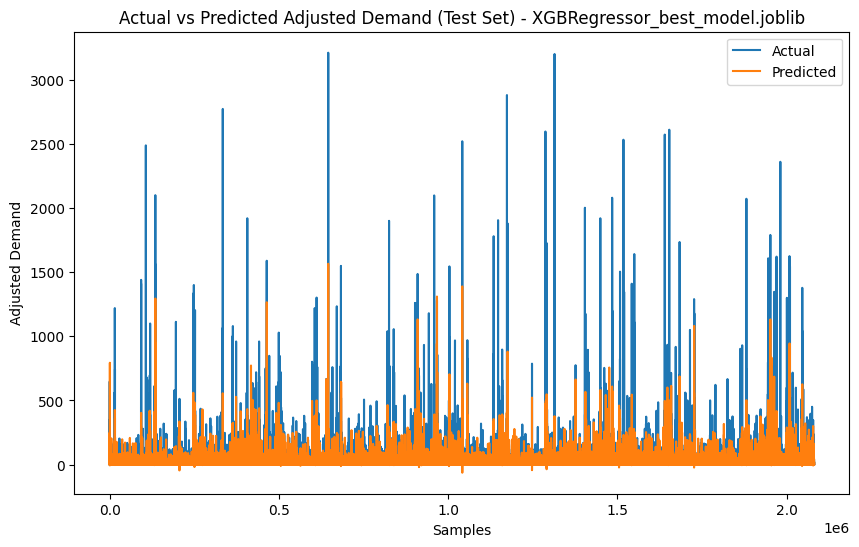

Loaded model from /kaggle/working/CatBoostRegressor_best_model.joblib
Test RMSE: 16.615606351480384
Test R-squared: 1.0


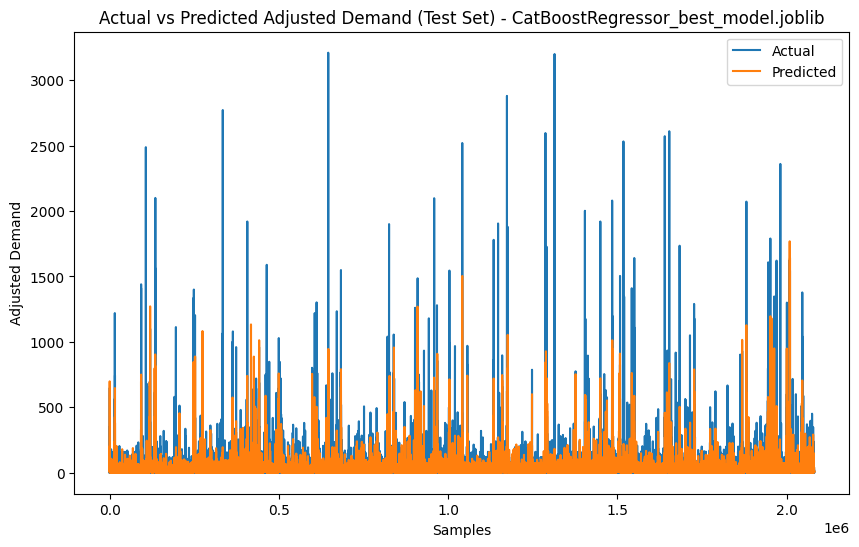

Loaded model from /kaggle/working/LGBMRegressor_best_model.joblib
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Test RMSE: 16.026896476080978
Test R-squared: 1.0


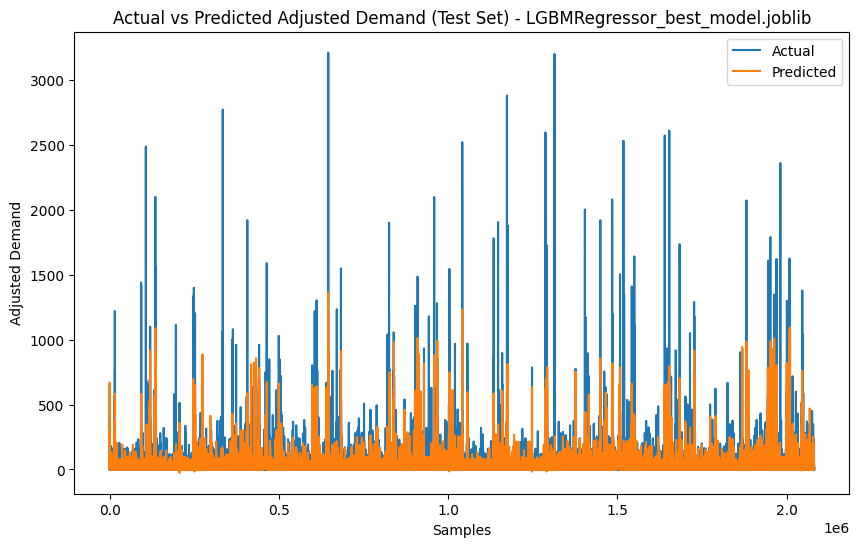

7422

In [52]:
def load_and_evaluate_models(model_directory, X_test, y_test):
    # List all files in the model directory
    model_files = [f for f in os.listdir(model_directory) if f.endswith('.joblib')]
    # Iterate over the found model files
    for model_file in model_files:
        # Load the model
        model_path = os.path.join(model_directory, model_file)
        model = joblib.load(model_path)
        print(f"Loaded model from {model_path}")

        # Predict on the test set
        y_test_pred = model.predict(X_test)

        # Evaluate the model on the test set
        test_mse = mean_squared_error(y_test, y_test_pred)
        test_rmse = np.sqrt(test_mse)
        test_r2 = r2_score(y_test, y_test_pred)

        print(f'Test RMSE: {test_rmse}')
        print(f'Test R-squared: {test_r2}')
        
        # Plot actual vs predicted values for test set
        plt.figure(figsize=(10, 6))
        plt.plot(y_test.values, label='Actual')
        plt.plot(y_test_pred, label='Predicted')
        plt.title(f'Actual vs Predicted Adjusted Demand (Test Set) - {model_file}')
        plt.xlabel('Samples')
        plt.ylabel('Adjusted Demand')
        plt.legend()
        plt.show()
    del model
    del y_test_pred
model_directory = CFG.MODEL_SAVE_PATH
load_and_evaluate_models(model_directory, X_test, y_test)
# Cleanup after execution
del X_train
del y_train
gc.collect()

### <b>5.4 <span style='color:#E1B12D'> Ensembling for Performance Improvement </span></b> 

In [53]:
def load_models(model_directory):
    models = {}
    for model_name in ['LGBMRegressor_best', 'XGBRegressor_best', 'CatBoostRegressor_best']:
        file_path = os.path.join(model_directory, f"{model_name}_model.joblib")
        models[model_name] = joblib.load(file_path)
    return models

# Load models from the specified directory
models = load_models('/kaggle/working/')

def objective(trial):
    # Suggest weights for each model
    w_xgboost = trial.suggest_float('w_xgboost', 0, 1)
    w_catboost = trial.suggest_float('w_catboost', 0, 1)
    w_lightgbm = trial.suggest_float('w_lightgbm', 0, 1)

    # Normalize weights so they sum to 1
    total = w_xgboost + w_catboost + w_lightgbm
    w_xgboost, w_catboost, w_lightgbm = w_xgboost / total, w_catboost / total, w_lightgbm / total

    # Create a VotingRegressor with the suggested weights
    voting_regressor = VotingRegressor(
        estimators=[
            ('xgboost', models['XGBRegressor_best']),
            ('catboost', models['CatBoostRegressor_best']),
            ('lightgbm', models['LGBMRegressor_best'])
        ],
        weights=[w_xgboost, w_catboost, w_lightgbm]
    )

    # Fit the VotingRegressor (assuming X_train and y_train are your data)
    voting_regressor.fit(X_test, y_test)

    # Predict using the VotingRegressor
    y_pred = voting_regressor.predict(X_test)

    # Calculate and return the RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(rmse)
    return rmse

In [54]:
# Set up Optuna study
study = optuna.create_study(direction='minimize')
score = study.optimize(objective, n_trials=2)
best_weights = [study.best_trial.params['w_xgboost'], study.best_trial.params['w_catboost'], study.best_trial.params['w_lightgbm']]
total = sum(best_weights)
best_weights = [w / total for w in best_weights]  
best_voting_regressor = VotingRegressor(
        estimators=[
            ('xgboost', models['XGBRegressor_best']),
            ('catboost', models['CatBoostRegressor_best']),
            ('lightgbm', models['LGBMRegressor_best'])
        ],
        weights=best_weights
    )
best_voting_regressor.fit(X_test, y_test)
joblib.dump(best_voting_regressor, '/kaggle/working/best_voting_regressor.joblib')

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2134
[LightGBM] [Info] Number of data points in the train set: 2081361, number of used features: 11
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 5 dense feature groups (15.88 MB) transferred to GPU in 0.022420 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 7.244955
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] 

['/kaggle/working/best_voting_regressor.joblib']

<a id="6"></a>
## <b>6 <span style='color:#E1B12D'> Model Inference </span></b> 
### <b>6.1 <span style='color:#E1B12D'> Loading the Model </span></b> 

In [55]:
voting_regressor = joblib.load('/kaggle/working/best_voting_regressor.joblib')

### <b>6.2 <span style='color:#E1B12D'> Data Loading and Prepration </span></b> 

### 6.2.1 Reading the data

In [86]:
test_df = pd.read_csv(test_file, compression='zip')

### 6.2.1 Combining the data
test_df

In [87]:
def prediction_data_preparation(test_df,train_df,week):
    test_df = test_df[test_df['Semana']==week]
    test_df = test_df.drop('id',axis=1)
    test_df = prepare_data(test_df)
    week_to_cover_rolling_feature = pd.to_datetime('2024-01-01') + pd.to_timedelta((week-3)*7, unit='D')
    _train_df=train_df[train_df.index >=week_to_cover_rolling_feature]
    test_df = pd.concat([test_df,_train_df])
    return test_df

In [89]:
train_df.index.dtype

dtype('<M8[ns]')

In [88]:
_test_df = prediction_data_preparation(test_df,train_df,10)

Decreased by 60.7%


In [93]:
_test_df.head()

,Sales_Depot_ID,Sales_Channel_ID,Route_ID,Client_ID,Product_ID,Adjusted_Demand,Lagged_Demanda_1,Lagged_Demanda_2,Lagged_Demanda_3,Rolling_Mean_3,Rolling_Sum_3,Rolling_Std_3
Week,,,,,,,,,,,,
2024-03-11,2045,1,2831,4549769,32940,0,NaN,NaN,NaN,NaN,NaN,NaN
2024-03-11,1612,1,2837,4414012,35305,0,NaN,NaN,NaN,NaN,NaN,NaN
2024-03-11,1349,1,1223,397854,1240,0,NaN,NaN,NaN,NaN,NaN,NaN
2024-03-11,1336,1,1069,4387996,2233,0,NaN,NaN,NaN,NaN,NaN,NaN
2024-03-11,1217,1,1143,4446449,1240,0,NaN,NaN,NaN,NaN,NaN,NaN


In [97]:
def prepare_data(df):
    df = cast_data_types(df, CFG.DATA_TYPES)
    df = df.rename(CFG.COLUMN_RENAME,axis=1)
    if 'Adjusted_Demand' not in df.columns: # To take care of Prediction
        df['Adjusted_Demand']=0
    #Assuming Week 1 starts from 1st January 2024
    if 'Week'in df.columns:
        df['Week'] = pd.to_datetime('2024-01-01') + pd.to_timedelta(df['Week'].astype(int) * 7, unit='D')
        df.set_index('Week', inplace=True)
    df = reduce_memory_usage(df)
    return df

In [98]:
test_df = prepare_data(_test_df)

TypeError: Categorical is not ordered for operation min
you can use .as_ordered() to change the Categorical to an ordered one


In [92]:
test_df = pipeline.fit_transform(_test_df)
test_df.head()
del test_df

KeyError: 'Week'

In [70]:
week_to_cover_rolling_feature = pd.to_datetime('2024-01-01') + pd.to_timedelta((10-3)*7, unit='D')

In [72]:
train_df_=train_df[train_df.index >=week_to_cover_rolling_feature]

In [73]:
sorted(train_df_.index.unique())

[Timestamp('2024-02-19 00:00:00'),
 Timestamp('2024-02-26 00:00:00'),
 Timestamp('2024-03-04 00:00:00')]

In [63]:
test_df

,id,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID
2,2,10,2045,1,2831,4549769,32940
7,7,10,1612,1,2837,4414012,35305
8,8,10,1349,1,1223,397854,1240
11,11,10,1336,1,1069,4387996,2233
13,13,10,1217,1,1143,4446449,1240
...,...,...,...,...,...,...,...
6999238,6999238,10,1336,1,2106,1203863,37361
6999241,6999241,10,1378,1,1265,2021090,1212
6999242,6999242,10,1338,1,1201,789056,1146
6999245,6999245,10,1333,11,3905,1905253,35305


In [ ]:
submission_df=pd.DataFrame()
test_df = pd.read_csv(test_file, compression='zip')
test_df = test_df.rename({'Semana':'Week', 'Agencia_ID':'Sales_Depot_ID', 'Canal_ID':'Sales_Channel_ID', 'Ruta_SAK':'Route_ID', 'Cliente_ID':'Client_ID',
       'Producto_ID':'Product_ID', 'Demanda_uni_equil':'Adjusted_Demand'},axis=1)
test_df['Week'] = pd.to_datetime('2024-01-01') + pd.to_timedelta(test_df['Week'].astype(int) * 7, unit='D')
test_df.set_index('Week', inplace=True)
test_df = pd.concat([train_df[train_df.index>pd.to_datetime('2024-02-12')],test_df])
test_df = reduce_memory_usage(test_df)
test_df = lagged_feature_creation(test_df)
test_df = rolling_feature_creation(test_df,3)
gc.collect()
# test_df = pd.concat()
# submission_df['id']=test_df['id']
# test_df=test_df.drop('id',axis=1)

In [ ]:
test_df = test_df.drop('Adjusted_Demand',axis=1)
test_df.head()

In [ ]:
test_df_first_week=test_df[test_df.index==pd.to_datetime('2024-03-11')]
y_test_pred = model.predict(test_df_first_week)
test_df_first_week['Adjusted_Demand']=y_test_pred

In [ ]:
test_df_first_week

In [ ]:
test_df[test_df.index==pd.to_datetime('2024-03-18')].head()

In [ ]:
submission_df=pd.DataFrame()
test_df = pd.read_csv(test_file, compression='zip')
test_df = test_df.rename({'Semana':'Week', 'Agencia_ID':'Sales_Depot_ID', 'Canal_ID':'Sales_Channel_ID', 'Ruta_SAK':'Route_ID', 'Cliente_ID':'Client_ID',
       'Producto_ID':'Product_ID', 'Demanda_uni_equil':'Adjusted_Demand'},axis=1)
test_df['Week'] = pd.to_datetime('2024-01-01') + pd.to_timedelta(test_df['Week'].astype(int) * 7, unit='D')
test_df.set_index('Week', inplace=True)
test_df_first_week= test_df_first_week[['Sales_Depot_ID', 'Sales_Channel_ID', 'Route_ID', 'Client_ID',
           'Product_ID','Adjusted_Demand']]
test_df_1 = pd.concat([train_df[train_df.index>pd.to_datetime('2024-02-19')],test_df_first_week])
test_df = pd.concat([test_df_1,test_df[test_df.index==pd.to_datetime('2024-03-18')]])
test_df = reduce_memory_usage(test_df)
test_df = lagged_feature_creation(test_df)
test_df = rolling_feature_creation(test_df,3)
gc.collect()

In [ ]:
test_df_second_week=test_df[test_df.index==pd.to_datetime('2024-03-18')]

In [ ]:
test_df_second_week = test_df_second_week.drop('Adjusted_Demand',axis=1)

In [ ]:
y_test_pred = model.predict(test_df_second_week)
test_df_second_week['Adjusted_Demand']=y_test_pred

In [ ]:
submission = pd.concat([test_df_first_week,test_df_second_week])

In [ ]:
submission = submission[['Sales_Depot_ID', 'Sales_Channel_ID', 'Route_ID', 'Client_ID',
           'Product_ID','Adjusted_Demand']]

In [ ]:
submission=submission.reset_index()

In [ ]:
submission

In [ ]:
test_df = pd.read_csv(test_file, compression='zip')

In [ ]:
test_df

In [ ]:
test_df = test_df.rename({'Semana':'Week', 'Agencia_ID':'Sales_Depot_ID', 'Canal_ID':'Sales_Channel_ID', 'Ruta_SAK':'Route_ID', 'Cliente_ID':'Client_ID',
       'Producto_ID':'Product_ID', 'Demanda_uni_equil':'Adjusted_Demand'},axis=1)
test_df['Week'] = pd.to_datetime('2024-01-01') + pd.to_timedelta(test_df['Week'].astype(int) * 7, unit='D')
# test_df.set_index('Week', inplace=True)

In [ ]:
test_df

In [ ]:
submission = submission.merge(test_df,on=['Week','Sales_Depot_ID', 'Sales_Channel_ID', 'Route_ID', 'Client_ID',
           'Product_ID'],how='inner')

In [ ]:
submission

In [ ]:
submission = submission[['id','Adjusted_Demand']]

In [ ]:
submission=submission.sort_values(by='id')

In [ ]:
submission_df['Demanda_uni_equil'] =y_test_pred

In [ ]:
submission=submission.rename({'Adjusted_Demand':'Demanda_uni_equil'},axis=1)

In [ ]:
submission.columns

In [ ]:
submission.to_csv('submission.csv',index=False)

In [ ]:
submission_df = pd.read_csv('/kaggle/input/grupo-bimbo-inventory-demand/sample_submission.csv.zip', compression='zip')

In [ ]:
submission_df

In [ ]:
submission_df.to_csv('submission.csv',index=False)